In [1]:
import os
import gc
import re
import torch
import transformers
import unicodedata
import pandas as pd
import numpy as np
import tokenizers
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold,train_test_split
from datasets import Dataset
import string
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel, AutoConfig,AutoModelForSequenceClassification
from tqdm import tqdm
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from sklearn.metrics import f1_score, classification_report

In [2]:
run_type = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if run_type == 'Interactive':
    print('Wandb in offline mode.')
    os.environ['WANDB_MODE'] = 'offline'
print('Authenticating with wandb.')
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_creds = user_secrets.get_secret("wandb")

!wandb login {wandb_creds}   

Authenticating with wandb.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
df=pd.read_csv("../input/ecommerce-text-classification/ecommerceDataset.csv")

In [4]:
df=df.dropna()

In [5]:
new_row={'Household':'Household','Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal bliss.so bring home this elegant print that is lushed with rich colors that makes it nothing but sheer elegance to be to your friends and family.it would be treasured forever by whoever your lucky recipient is. Liven up your place with these intriguing paintings that are high definition hd graphic digital prints for home, office or any room.':'Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal bliss.so bring home this elegant print that is lushed with rich colors that makes it nothing but sheer elegance to be to your friends and family.it would be treasured forever by whoever your lucky recipient is. Liven up your place with these intriguing paintings that are high definition hd graphic digital prints for home, office or any room.'}
df = df.append(pd.DataFrame([new_row],index=[0],columns=df.columns))
df.columns=["Categories","Description"]
df=df.reset_index().drop('index',axis=1)

In [6]:
df['Categories'].unique()

array(['Household', 'Books', 'Clothing & Accessories', 'Electronics'],
      dtype=object)

In [7]:
df['Description'][25000]

'the princess saves herself in this one (Women Are Some Kind of Magic 1) Review "It blends fairy tale lore with real-life musings for a beautiful result."\xa0(Lindsay E. Mack, Romper)"As a whole, the collection acts as a tribute to all women who have ever needed a boost of empowerment and inspiration."\xa0(Madison Breaux, V Magazine)"...Amanda Lovelace dives into the topics of modern feminism and empowerment...Read if you\'ve ever thought about love, loss, who you are, and what you want. (So...all of us.)"\xa0(Abigail Yonker, The Everygirl)"This is the book to read if you are on the path to writing your own ending and finding yourself, even when the road to accomplishment is rocky."\xa0(Dominique Etzel, Alloy)"Similar in style—written in straightforward and uncomplicated verse, and content—grappling with themes of female power, love and loss, failure and redemption, pain and healing, poet Amanda Lovelace\'s\xa0The Princess Saves Herself in this One\xa0is similar to Kaur\'s\xa0Milk and 

In [8]:
def encoding(text):
    text= unicodedata.normalize("NFKD",text)
    """
        Remove unicoded data
    """
    return text
def remove_URL(text):
    """
        Remove URLs 
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)
def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text)
def remove_html(text):
    """
        Remove the html 
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)
def remove_punct(text):
    """
        Remove the punctuation
    """
#     return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)
    return text.translate(str.maketrans('', '', string.punctuation))

In [9]:
df['Description']=df['Description'].apply(encoding)
df['Description']=df['Description'].apply(lambda x: x.lower())
df['Description']=df['Description'].apply(remove_URL)
df['Description']=df['Description'].apply(remove_non_ascii)
df['Description']=df['Description'].apply(remove_html)
df['Description']=df['Description'].apply(remove_punct)

In [10]:
df['Description'][10]

'paper plane design starry night vangoh wall art canvas painting large size rolled canvas art print 36 x 48 we use only the most modern and efficient printing technology on our canvases with only the best and original inks and precision epson roland and hp printers this innovative hd printing technique results in durable and spectacular looking prints of the highest quality that last a lifetime we print solely with topnotch inks to achieve brilliant and true colours due to their high level of uv resistance our canvas prints retain their beautiful colours for many years our canvases contain high levels of white to ensure that the colours of your original image are reproduced exactly with brilliant tones add colour and style to your living space with this digitally printed canvas painting some gifts are for pleasure and some for eternal blissso bring home this elegant canvas print that is lushed with rich colors that makes it nothing but sheer elegance to be gifted to your friends and fa

In [11]:
min_length=df['Description'].str.len().min()
max_length=df['Description'].str.len().max()
average_length=df['Description'].str.len().mean()
median_length=df['Description'].str.len().median()
print("Min_Length :",min_length)
print("Max_Length :",max_length)
print("Mean_Length :",average_length.round(0).astype(int))
print("Median_length :",median_length.astype(int))

Min_Length : 3
Max_Length : 48994
Mean_Length : 690
Median_length : 470


In [12]:
df['ncharacters'] = df['Description'].str.len()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Character Count')

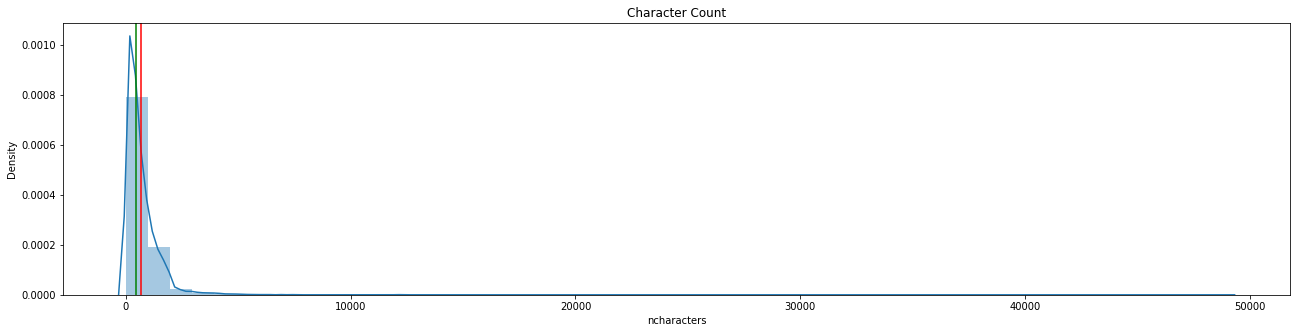

In [13]:
plt.figure(figsize = (22,5))
sns.distplot(df['ncharacters'])
plt.axvline(x = average_length, color = 'red')
plt.axvline(x = median_length, color = 'green')
plt.title('Character Count')

In [14]:
df.groupby('Categories').count()

,Description,ncharacters
Categories,,
Books,11820,11820
Clothing & Accessories,8670,8670
Electronics,10621,10621
Household,19313,19313


In [15]:
X=df.drop('Categories',axis=1)
y=df.Categories

In [16]:
class config:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    seed = 42   
    save_dir="./"
    
    #tokenizer params
    truncation = True 
    padding = True
    max_length = 1024
    
    # model params
    model_name = "microsoft/deberta-v3-base"
    #training params
    learning_rate = 2e-6
    batch_size = 2
    epochs = 5
    NFOLDS = 5
    
TOKENIZERS_PARALLELISM=True    

In [17]:
skf = StratifiedKFold(n_splits=config.NFOLDS,shuffle=True,random_state=42)
df["fold"] = -1
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df["Categories"] )):
    df.loc[val_idx, "fold"] = fold


In [18]:
df.groupby('fold').count()

,Categories,Description,ncharacters
fold,,,
0,10085,10085,10085
1,10085,10085,10085
2,10085,10085,10085
3,10085,10085,10085
4,10084,10084,10084


In [19]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [20]:
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
tokenizer.save_pretrained(config.save_dir+'tokenizer/')
config.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
model = AutoModelForSequenceClassification.from_pretrained(config.model_name,num_labels=4)
model.to(device)

Downloading:   0%|          | 0.00/354M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
 

In [23]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val
                in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [24]:
def compute_metrics(p):
    prediction, labels = p
    preds_flat = np.argmax(prediction, axis=1).flatten()
    labels_flat = labels.flatten()
    f1 = f1_score(labels_flat, preds_flat, average='macro')
    return {"f1": f1}

In [25]:
descriptions = df["Description"].map(str).values.tolist()
labels = df["Categories"].values.tolist()

le = LabelEncoder()
labels = le.fit_transform(labels).tolist()

In [26]:
def get_batch_tokenizer(tokenizer, dataset):
    return tokenizer.batch_encode_plus(dataset,
                                       max_length=512,
                                       padding=True,
                                       truncation=True,
                                       add_special_tokens=True,
                                       return_attention_mask=True,
                                       return_tensors='pt')

In [27]:
x_train, x_test, y_train, y_test = train_test_split(descriptions, labels, test_size=0.4, stratify=labels, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [28]:
torch.cuda.empty_cache()

In [29]:
#    valid_labels = valid_folds[CFG.target_cols].values
#x_train, x_valid, y_train, y_valid = train_test_split(descriptions,labels, test_size=0.3, stratify=labels, random_state=42)
#x _valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
x_train_tokens = get_batch_tokenizer(tokenizer, x_train)
x_valid_tokens = get_batch_tokenizer(tokenizer, x_valid)
x_test_tokens = get_batch_tokenizer(tokenizer, x_test)
#y_train = df['Category']
#y_valid = df['Category']
train_dataset = Dataset(x_train_tokens, y_train)
valid_dataset = Dataset(x_valid_tokens, y_valid)
test_dataset = Dataset(x_test_tokens, y_test)
gc.collect() 

args = TrainingArguments(output_dir="output",
                            evaluation_strategy="epoch",
                            metric_for_best_model="f1",
                            save_strategy="epoch",
                            num_train_epochs=config.epochs,
                            load_best_model_at_end=True
                         
                            )
trainer = Trainer(args=args,
                    model=model,
                    train_dataset=train_dataset,
                    eval_dataset=valid_dataset,
                    compute_metrics=compute_metrics,
                    callbacks=[EarlyStoppingCallback(
                            early_stopping_patience=3)]
                    )

In [30]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 30254
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18910
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: harshitkmr. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Epoch,Training Loss,Validation Loss,F1
1,0.360800,0.327737,0.941605
2,0.302800,1.014642,0.648218
3,0.251100,0.298433,0.945340
4,0.233400,0.243710,0.957673
5,0.185800,0.240738,0.958202


***** Running Evaluation *****
  Num examples = 10085
  Batch size = 8
Saving model checkpoint to output/checkpoint-3782
Configuration saved in output/checkpoint-3782/config.json
Model weights saved in output/checkpoint-3782/pytorch_model.bin
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 10085
  Batch size = 8
Saving model checkpoint to output/checkpoint-7564
Configuration saved in output/checkpoint-7564/config.json
Model weights saved in output/checkpoint-7564/pytorch_model.bin
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.ten

TrainOutput(global_step=18910, training_loss=0.27807881977115595, metrics={'train_runtime': 14158.791, 'train_samples_per_second': 10.684, 'train_steps_per_second': 1.336, 'total_flos': 3.980223783653376e+16, 'train_loss': 0.27807881977115595, 'epoch': 5.0})

In [31]:
trainer = Trainer(model=model)
predictions = trainer.predict(test_dataset)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 10085
  Batch size = 8
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [32]:
preds = np.argmax(predictions.predictions, axis=1).flatten()
true_vals = predictions.label_ids

In [33]:
print(classification_report(true_vals, preds, target_names=list(le.classes_)))

                        precision    recall  f1-score   support

                 Books       0.95      0.96      0.95      2335
Clothing & Accessories       0.98      0.97      0.97      1772
           Electronics       0.95      0.93      0.94      2111
             Household       0.95      0.96      0.96      3867

              accuracy                           0.95     10085
             macro avg       0.96      0.95      0.96     10085
          weighted avg       0.95      0.95      0.95     10085

